In [1]:
import numpy as np
np.random.seed(4)
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
import datetime

In [1]:
pip install pandas-datareader

Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, LSTM
from keras.models import Sequential

In [3]:
#
# Funciones auxiliares
#
def graficar_predicciones(real, prediccion):
    plt.plot(real[0:len(prediccion)],color='red', label='Valor real de la acción')
    plt.plot(prediccion, color='blue', label='Predicción de la acción')
    plt.ylim(1.1 * np.min(prediccion)/2, 1.1 * np.max(prediccion))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()
    plt.show()

In [4]:
#
# Lectura de los datos
#
#dataset = pd.read_csv('Futuros del Índice S&P 500 - Este es el bueno.csv', index_col='Fecha', parse_dates=['Fecha'])
#dataset.head()
start = datetime.datetime(2015,1,1)
end = datetime.datetime(2020,12,31)
dataset = web.get_data_yahoo('VOO','01/01/2015',interval='m')
dataset.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-01,189.720001,182.089996,189.289993,182.990005,51629600.0,162.489365
2015-02-01,194.649994,181.470001,183.500000,193.199997,30737100.0,171.555527
2015-03-01,194.470001,187.149994,193.309998,189.199997,35632400.0,168.003632
2015-04-01,194.740005,187.470001,189.169998,191.100006,30252000.0,170.556534
2015-05-01,195.949997,189.529999,191.960007,193.490005,25759100.0,172.689636


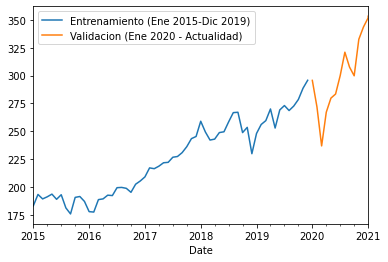

In [7]:
#
# Sets de entrenamiento y validación 
# La LSTM se entrenará con datos de 2016 hacia atrás. La validación se hará con datos de 2017 en adelante.
# En ambos casos sólo se usará el valor más alto de la acción para cada día
#

set_entrenamiento = dataset['2015':'2019'].iloc[:,3:4]
set_validacion = dataset['2020':].iloc[:,3:4]
set_entrenamiento['Close'].plot(legend=True)
set_validacion['Close'].plot(legend=True)
plt.legend(['Entrenamiento (Ene 2015-Dic 2019)', 'Validacion (Ene 2020 - Actualidad)'])
plt.show()

In [8]:
# Normalización del set de entrenamiento
sc = MinMaxScaler(feature_range=(0,1))
print(sc)
print(set_entrenamiento)
set_entrenamiento_escalado = sc.fit_transform(set_entrenamiento)

MinMaxScaler()
                 Close
Date                  
2015-01-01  182.990005
2015-02-01  193.199997
2015-03-01  189.199997
2015-04-01  191.100006
2015-05-01  193.490005
2015-06-01  188.839996
2015-07-01  192.949997
2015-08-01  181.110001
2015-09-01  175.710007
2015-10-01  190.559998
2015-11-01  191.369995
2015-12-01  186.929993
2016-01-01  177.750000
2016-02-01  177.380005
2016-03-01  188.559998
2016-04-01  189.220001
2016-05-01  192.539993
2016-06-01  192.199997
2016-07-01  199.279999
2016-08-01  199.520004
2016-09-01  198.690002
2016-10-01  195.130005
2016-11-01  202.399994
2016-12-01  205.309998
2017-01-01  208.970001
2017-02-01  217.070007
2017-03-01  216.350006
2017-04-01  218.600006
2017-05-01  221.669998
2017-06-01  222.059998
2017-07-01  226.639999
2017-08-01  227.300003
2017-09-01  230.759995
2017-10-01  236.130005
2017-11-01  243.350006
2017-12-01  245.289993
2018-01-01  258.989990
2018-02-01  249.339996
2018-03-01  242.080002
2018-04-01  242.919998
2018-05-01  248.789

## La red LSTM tendrá como entrada "time_step" datos consecutivos, y como salida 1 dato (la predicción a
# partir de esos "time_step" datos). Se conformará de esta forma el set de entrenamiento
time_step = 726
X_train = []
Y_train = []
m = len(set_entrenamiento_escalado)

In [9]:
time_step = 3
X_train = [] 
Y_train = [] 
m = len(set_entrenamiento_escalado)

In [10]:
for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(set_entrenamiento_escalado[i-time_step:i,0])
    # Y: el siguiente dato
    Y_train.append(set_entrenamiento_escalado[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
len(X_train)

57

In [11]:
#
# Red LSTM
#
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
print(dim_entrada)
na = 120

modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))
modelo.compile(optimizer='rmsprop', loss='mse')
modelo.fit(X_train,Y_train,epochs=20,batch_size=12)

(3, 1)
Epoch 1/20
5/5 [==============================] - 7s 4ms/step - loss: 0.2163
Epoch 2/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0695
Epoch 3/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0253
Epoch 4/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0223
Epoch 5/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0166
Epoch 6/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 7/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0111
Epoch 8/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0099
Epoch 9/20
5/5 [==============================] - 0s 3ms/step - loss: 0.0105
Epoch 10/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 11/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 12/20
5/5 [==============================] - 0s 4ms/step - loss: 0.0076
Epoch 13/20
5/5 [==============================] - 0s 4ms/step - l

                 Close
Date                  
2020-01-01  295.690002
2020-02-01  271.739990
2020-03-01  236.820007
2020-04-01  267.100006
2020-05-01  279.750000
2020-06-01  283.429993
2020-07-01  300.100006
2020-08-01  321.019989
2020-09-01  307.649994
2020-10-01  299.820007
2020-11-01  332.640015
2020-12-01  343.690002
2021-01-01  351.899994
2021-01-25  353.329987
[[285.67767]
 [264.9862 ]
 [260.90717]
 [282.81473]
 [294.79294]
 [308.19968]
 [323.904  ]
 [328.8857 ]
 [324.67996]
 [336.55212]
 [363.28625]]


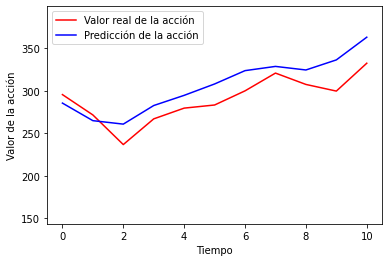

In [12]:
#
# Validación (predicción del valor de las acciones)
#

x_test = set_validacion.values
x_test = sc.transform(x_test)

X_test = []

m = len(x_test)
for i in range(time_step,m):
  X_test.append(x_test[i-time_step:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

prediccion = modelo.predict(X_test)
prediccion = sc.inverse_transform(prediccion)

# Graficar resultados
print(set_validacion)
print(prediccion)
graficar_predicciones(set_validacion.values,prediccion)